##  Chapter 8: Linear unsupervised learning

# Exercises

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import math_optimization_library as optlib
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# plotting utilities
import matplotlib.pyplot as plt
from matplotlib import gridspec

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.2.5  The block-coordinate descent PCA solution*

While the orthonormal PCA solution is by far more popular, we could in theory recover an infinite variety of spanning sets for our data in minimizing the Least Squares cost in equation (2) using standard optimization techniques including gradient descent and block-coordinate descent.  Here we discuss in particular the *block-coordinate* descent approach hinted at in Section 9.2.1 above, where we will use $K \leq N$ elements.  The main value in going through this exercise basis is that - as we will see - PCA is the prototypical method on which all other fundamental unsupervised methods (where we cannot derive special orthonormal solutions like we can with PCA) are based.  Because of this we will often see the use of block-coordinate descent in the future, with updates that closely mirror what we derive (in the relatively simpler context of PCA).

So - how do we go about cooking up a block-coordinate descent method for minimizing the Least Squares cost for PCA in equation (2) - again assuming we use an arbitrary $K \leq N$ basis elements?  First note that there are a number of ways we can express equation (2) and multiple orders in which we could perform block-updates on its parameters.  For the sake of consistency with the natural block-update structure we will see with further unsupervised learning methods, here update *one column of parameters at a time*.  To do this we first  re-write equation (2) by expressing each multiplication $\mathbf{C}_{\,}\mathbf{w}_p = \sum_{n=1}^K\mathbf{c}_nw_{n,p}$ in terms of the *columns* of $\mathbf{C}$ (as in equation (1)).  Doing this we can write equation (2) equivalently (again assuming the use of $K \leq N$ basis vectors $\mathbf{c}_1,...,\mathbf{c}_K$) exposing each set of parameters as a column vector as 

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{c}_1,...,\mathbf{c}_K\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \sum_{n=1}^K\mathbf{c}_nw_{n,\,p} - \mathbf{x}_p \right\Vert_2^2
\end{equation}

where $w_{n,\,p}$ denotes the $n^{th}$ element of $\mathbf{w}_p$.


To minimize our cost function one-column of parameters at a time we first sweep through $\mathbf{w}_1$ through $\mathbf{w}_P$, solving the first order system in each case (keeping all other parameters fixed).  Then we do the same for $\mathbf{c}_1$ through $\mathbf{c}_K$.  Beginning with the weights it is straight forward to confirm (as we computed in Section 9.1.1 when computing weights for a fixed basis representation) that the first order system for each $\mathbf{w}_p$ is given as 

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,}\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P .
\end{equation}

Since $\mathbf{C}$ is an $N \times K$ matrix, each of these systems is $K\times K$, symmetric, and linear.  Hence we can solve the $p^{th}$ easily via e.g., coordinate descent in the individual elements of $\mathbf{w}_p$.

Remember that *regularizing* a system like this often helps avoid numerical instability issues associated with solving linear systems like this in practice.   To do this we add a weighted identity to the matrix of the system - here $\mathbf{C}^T\mathbf{C}^{\,}$ - meaning that in practice here we often solve linear systems of the following adjusted form

\begin{equation}
\left(\mathbf{C}^T\mathbf{C}^{\,} + \lambda\mathbf{I}_{K\times K} \right)\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P 
\end{equation}

where $\lambda \geq 0$ is typically set to some small value (like e.g., $10^{-5}$).

Once each of these weight updates is made we can then move on to solve the first order system in each column of $\mathbf{C}$.  Again one can quickly check (using the re-written form of equation (2) above) that the $n^{th}$ of these updates each these updates takes the exceedingly simple form

\begin{equation}
\mathbf{c}_n = \frac{\sum_{p=1}^P \mathbf{x}_p w_{n,\,p} } {\sum_{p=1}^P w_{n,\,p}^2}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, n=1...K.
\end{equation}

Practically speaking, to guard against the possibility where the denominator of one of these fractions is extremely small or zero it is commonplace here to also *regularize* each 'system' by adding a small nonnegative value to the denominator of each update formula above.  Hence instead of the updates above we typically in practice solve for the related updates

\begin{equation}
\mathbf{c}_n = \frac{\sum_{p=1}^P \mathbf{x}_p w_{n,\,p} } {\sum_{p=1}^P w_{n,\,p}^2 + \lambda} \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, n=1...K
\end{equation}

where $\lambda \geq 0$ is some small value (like e.g., $10^{-5}$).

Taken together, the regularization of both sets of optimization vectors introduced to avoid numerical issues is actually equivalent to regularizing both in the original cost function.  Using the same parameter $\lambda$ for both sets of variables this regularized Least Squares cost function PCA looks like the following

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{c}_1,...,\mathbf{c}_K\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \sum_{n=1}^K\mathbf{c}_nw_{n,\,p} - \mathbf{x}_p \right\Vert_2^2 + \frac{\lambda}{P}\sum_{n=1}^K\left\Vert \mathbf{c}_n \right \Vert_2^2 + \frac{\lambda}{P}\sum_{p=1}^P\left\Vert \mathbf{w}_p \right \Vert_2^2.
\end{equation}

And indeed checking the first order condition in each vector of parameters will find that they lead precisely to the regularized update formula given above.

In any case - repeating these updates multiple times produces convergence to an ideal basis / set of weight vectors for the dataset.  Moreover this particular formulation of the block-coordinate approach is simple to implement and - as we will see - is a prototype algorithm for many other fundamental linear unsupervised learning methods (as we will see in the forthcoming Sections).  Pseudo-code containing this algorithm is given below, followed by a Python implementation and computational example employing it.

### PCA algorithm  (block-coordinate descent) 

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> a number $K \leq N$ of desired principal components, dataset $\mathbf{x}_1,...,\mathbf{x}_P$, initializations for basis $\mathbf{c}_1,...,\mathbf{c}_K$, reguliarzation parameter $\lambda$, and maximum number of iterations $\text{max_its}$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>compute</code> mean of dataset $\boldsymbol{\mu} = \frac{1}{P}\sum_{p=1}^P\mathbf{x}_p$ and center data as $\mathbf{x}_p \longleftarrow \mathbf{x}_p - \boldsymbol{\mu}$ for $p=1,...,P$ <br> 

<strong>3:</strong>&nbsp;&nbsp; <code>for</code> $\,\,i = 1,\ldots,\text{max_its}$<br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update weight vectors</code><br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\left(\mathbf{C}^T\mathbf{C}^{\,} + \lambda \mathbf{I}_{K\times K}\right)\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p$ for $\mathbf{w}_p$ <br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update basis</code><br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,n = 1,\ldots,K$<br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\mathbf{c}_n = \frac{\sum_{p=1}^P \mathbf{x}_p w_{n,p} } {\sum_{p=1}^P w_{n,p}^2 + \lambda}$<br>

<strong>11:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>12:</strong>&nbsp; <code>end for</code><br>

<strong>13:</strong>&nbsp;&nbsp; <code># Update weights on final basis</code><br>


<strong>14:</strong>&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>15:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\left(\mathbf{C}^T\mathbf{C}^{\,} + \lambda \mathbf{I}_{K\times K}\right)\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p$ for $\mathbf{w}_p$ <br>

<strong>16:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>17:</strong>&nbsp; <strong>output:</strong> optimal PCA basis $\mathbf{c}_1,...,\mathbf{c}_K$ and weights $\mathbf{w}_1,...,\mathbf{w}_P$<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

In the next cell we have our implementation.  Note: we write this implementation so that it mirrors the pseudo-code above, and integrate in some numerically efficient steps not shown in the pseudo-code (like e.g., computing $\mathbf{C}^T\mathbf{C} + \lambda\mathbf{I}_{K\times K}$ only once per set of weight updates).  However this could be made significantly faster in ``Python`` by updating the entire set of weight vectors simultaneously (instead of looping through each vector one-at-a-time), and then by doing the same with the entire set of basis vectors.  

In [28]:
# PCA Least Squares cost function - useful for debugging / stopping conditions
def PCA_cost(X,C,W,lam):
    N,P = np.shape(X)
    return  np.linalg.norm(np.dot(C,W) - X,'fro')**2/float(P) + lam/float(P)*np.linalg.norm(C,'fro')**2 + lam/float(P)*np.linalg.norm(W,'fro')**2

# update weights w_1...w_P
def update_weights(X,C,lam):
    # Update weight vectors
    N,P = X.shape
    W = []
    
    # pre-compute elements of each linear system
    CTC = np.dot(C.T,C) 
    
    # regularize matrix of linear system to avoid numerical instability issues
    CTC += lam*np.eye(np.shape(C)[1])   
    for p in range(P):
        # setup linear system
        w_p = np.array(np.linalg.solve(CTC,np.dot(C.T,X[:,p][:,np.newaxis]))).ravel()
        W.append(w_p)
        
    # return weight matrix
    W = np.array(W).T
    return W

# update basis / principal components c_1...c_K
def update_basis(X,W,lam):
    # Update basis vectors 
    K,P = W.shape
    C = []
    for n in range(K):
        # update nth element of basis
        c_n = np.sum(X*W[n,:][np.newaxis,:],axis = 1)/(np.sum(W[n,:]*W[n,:]) + lam)
        C.append(c_n)
        
    # return updated basis
    C = np.array(C).T
    return C

# main function for running block-coordinate descent
def block_coord_PCA(X,C,max_its,lam):
    # Outer loop - over iterations
    cost_history = []  # container to store cost function value at each weight update
    for i in range(max_its):
        # update weights
        W = update_weights(X,C,lam)

        # calculate current cost value
        cost = PCA_cost(X,C,W,lam)
        cost_history.append(cost)
    
        # update basis
        C = update_basis(X,W,lam)
        
    # final weight update
    W = update_weights(X,C,lam)
    
    # calculate current cost value
    cost = PCA_cost(X,C,W,lam)
    cost_history.append(cost)
    
    # return PCs and weights
    return C,W,cost_history

#### <span style="color:#a50e3e;">Example 4: </span> Dimension reduction using block-coordinate solution to PCA

In this example we repeat the experiment shown first in Example 4, where we find the best two-dimensional subspace to project a three-dimensional dataset.  First - in the next cell - we load in the dataset and run the block-coordinate descent algorithm above in order to identify the best $K=2$ dimensional subspace for the dataset.  To ensure that our code is working properly we plot the cost function history for 10 iterations of the algorithm.

<IPython.core.display.Javascript object>


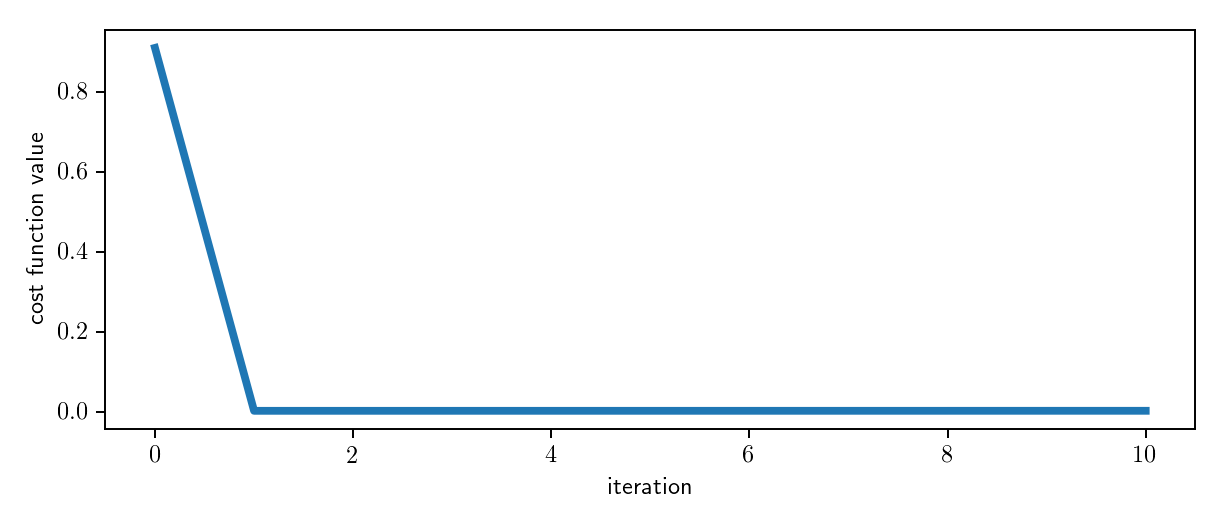

In [29]:
# load in dataset to perform PCA on
X_original = np.loadtxt(datapath + '3d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the two-dimensional PCA transformation of dataset
K = 2
C = np.random.randn(3,K)
pcs,W,cost_history = block_coord_PCA(X,C,max_its = 10,lam = 10**(-5))

# plot cost function history
plotter = unsuplib.plot_utilities.Visualizer()
plotter.plot_cost_history(cost_history)

Of course we are able to recover the same subspace as we saw there, but with a non-orthonormal basis (and somewhat random basis).  The effect of this non-orthonormal basis can be most clearly seen in the right panel where the projected data - in the space of the located spanning vectors - is not as evenly distributed as when we used the orthonormal PCA solution.  

<IPython.core.display.Javascript object>


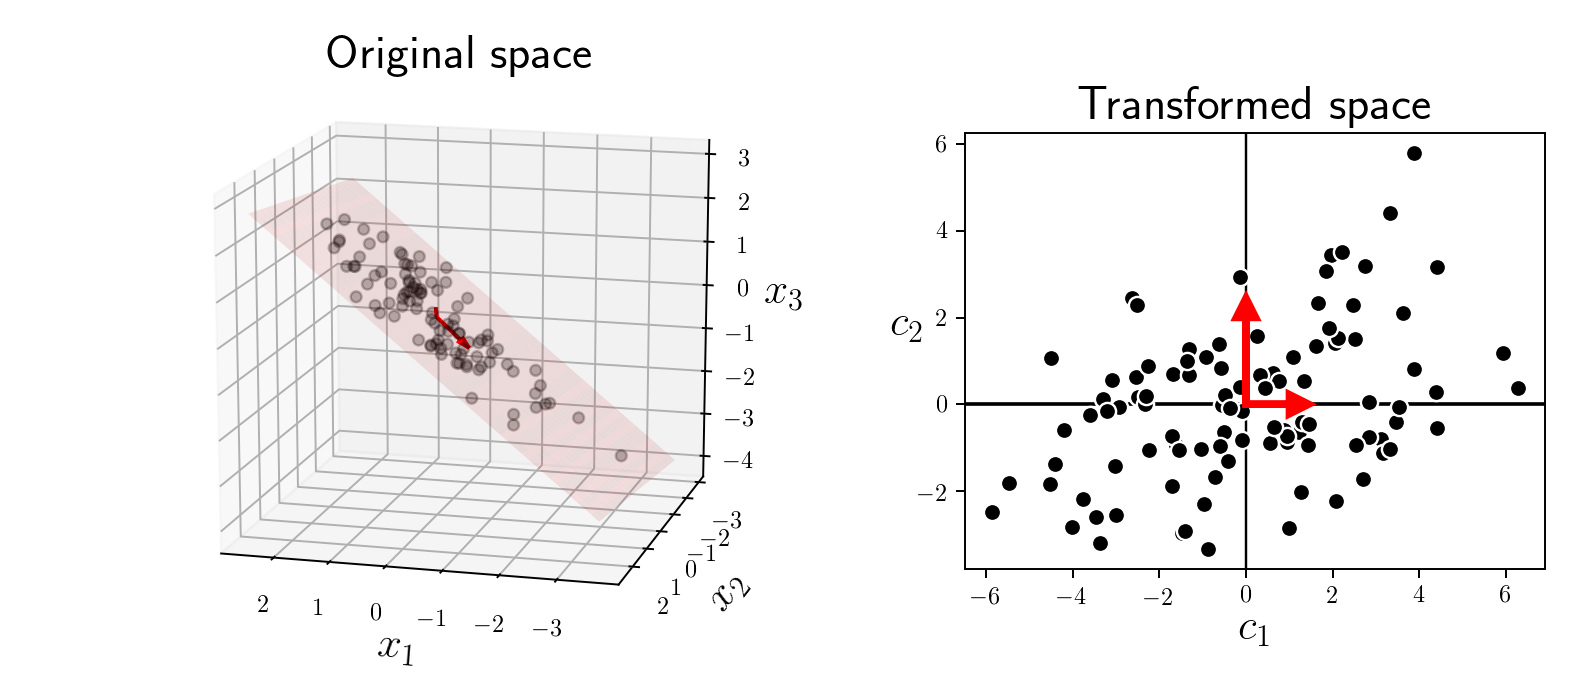

In [30]:
# produce visuals
init = [15,105]
unsuplib.PCA_demos.project_data_from_3d_to_2d(X,W,pcs,init)

## 11.4.3  The block-coordinate descent algorithm for Recommender Systems

So far we have seen how the setup and cost function of the linear Recommender Systems model mirrors PCA very closely.  Now we discuss how to minimize the Least Squares cost function above in order to recover optimal settings for our parameter vectors $\mathbf{w}_1,...,\mathbf{w}_p$ and $\mathbf{c}_1,...,\mathbf{c}_K$.  In the case of PCA, we saw in Section 9.2.2 how the additional assumption that our basis is *orthonormal* allowed us to derive mathematically simple forms for our ideal parameter vectors.  However here the additional wrinkle of the Recommender Systems model - that we only have access to data whose indices lie in the set $\Omega$ - prohibits similar calculations.  Thus in short we must rely on an iterative method for learning ideal parameters here like gradient descent or coordinate / block-coordinate descent. 

Earlier in Section 9.2.5 we also saw how a simple *block-coordinate descent* approach, where we update one vector of parameters at a time, is a natural choice of algorithm to sequentially minimize the PCA cost function when the assumption of orthonormality is *not* enforced.  Because we now face the task of minimizing a highly related cost function for Recommender Systems it makes sense that we should apply the same approach, and so we will.  In other words, we will sequentially minimize the cost function above by sweeping through first the set of weights $\mathbf{w}_1,...,\mathbf{w}_P$ solving the first order system in each $\mathbf{w}_p$ independently with all other parameters fixed, and then we do the same for $\mathbf{c}_1,...,\mathbf{c}_K$.  Working carefully through the equations one can formulate very similar updates to ones derived for PCA in Section 9.2.5.  

Additionally - as we saw with PCA - to avoid numerical instability issues it is helpful to *regularize* both sets of parameter vectors.  Adding regularizers to both $\mathbf{c}_n$ and $\mathbf{w}_p$ gives the regularized version of the cost

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{c}_1,...,\mathbf{c}_K\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \left.\left\{ \sum_{n=1}^K\mathbf{c}_nw_{n,\,p} - \mathbf{x}_p \right\}\right\vert_{\,\Omega_p}\right\Vert_2^2 + \frac{\lambda}{P}\sum_{n=1}^K\left\Vert \mathbf{c}_n \right \Vert_2^2 + \frac{\lambda}{P}\sum_{p=1}^P\left\Vert \mathbf{w}_p \right \Vert_2^2.
\end{equation}

Denoting by $\mathbf{C}$ our $N\times K$ basis matrix as

\begin{equation}
\mathbf{C} = \begin{bmatrix} 
\vert \,\,\,\,\,\, \vert \,\,\,\,\,...\,\,\,\,\vert \\
\mathbf{c}_1 \,\, \mathbf{c}_2 \,\,...\,\,\mathbf{c}_K \\
\vert \,\,\,\,\,\, \vert \,\,\,\,\,...\,\,\,\,\vert
\end{bmatrix}
\end{equation}

and $\mathbf{C}_{\Omega_p}$ as the $\left\vert\Omega_p\right\vert \times K$ submatrix consisting of the $j^{th}$ row of $\mathbf{C}$ for each $j \in \Omega_p$ the update step for $\mathbf{w}_p$ can be written as 

\begin{equation}
\left(\mathbf{C}_{\Omega_p}^T\mathbf{C}_{\Omega_p}^{\,} + \lambda \mathbf{I}_{\left\vert\Omega_p\right\vert \times \left\vert\Omega_p\right\vert} \right)\mathbf{w}_p = \mathbf{C}_{\Omega_p}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P .
\end{equation}

Notice how closely this resembles the analogous PCA update step.  Likewise the update step for $\mathbf{c}_n$ we can write the update step as 

\begin{equation}
\mathbf{c}_n = \frac{\sum_{p\, \text{if} \,n\in \Omega_p} \mathbf{x}_p w_{n,\,p} } {\sum_{p\, \text{if} \,n\in \Omega_p} w_{n,\,p}^2 + \lambda}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, n=1...K
\end{equation}

which mirrors the analogous update step for PCA very closely. 

Sweeping through the parameter vectors and performing these updates a number of times results in a proper solution to the Least Squares cost function detailed above.  Below we collect these update steps in a pseudo-code block for convenience.  Comparing this procedure to the block-coordinate descent algorithm described in Section 9.2.5, notice unsurprisingly that if the ratings matrix $\mathbf{X}$ were *complete* these update steps would be precisely those given for the block-coordinate update steps for PCA.

### Recommender systems  (block-coordinate descent) 

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> a number $K \leq N$ of desired basis elements, dataset $\mathbf{x}_1,...,\mathbf{x}_P$, initializations for basis $\mathbf{c}_1,...,\mathbf{c}_K$, maximum number of iterations $\text{max_its}$, and regularization parameter $\lambda$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,i = 1,\ldots,\text{max_its}$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update weight vectors</code><br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\left(\mathbf{C}_{\Omega_p}^T\mathbf{C}_{\Omega_p}^{\,} + \lambda \mathbf{I}_{\left\vert\Omega_p\right\vert \times \left\vert\Omega_p\right\vert} \right)\mathbf{w}_p = \mathbf{C}_{\Omega_p}^T\mathbf{x}_p$ <br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update basis</code><br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,n = 1,\ldots,K$<br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\mathbf{c}_n = \frac{\sum_{p\, \text{if} \,n\in \Omega_p} \mathbf{x}_p w_{n,\,p} } {\sum_{p\, \text{if} \,n\in \Omega_p} w_{n,\,p}^2 + \lambda}$ <br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>11:</strong>&nbsp; <code>end for</code><br>

<strong>12:</strong>&nbsp;&nbsp; <code># Update weights on final basis</code><br>


<strong>13:</strong>&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>14:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\left(\mathbf{C}_{\Omega_p}^T\mathbf{C}_{\Omega_p}^{\,} + \lambda \mathbf{I}_{\left\vert\Omega_p\right\vert \times \left\vert\Omega_p\right\vert} \right)\mathbf{w}_p = \mathbf{C}_{\Omega_p}^T\mathbf{x}_p$ <br>

<strong>15:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>16:</strong>&nbsp; <strong>output:</strong> optimal Recommender System basis $\mathbf{c}_1,...,\mathbf{c}_K$ and weights $\mathbf{w}_1,...,\mathbf{w}_P$<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

Below we show a ``Python`` implementation of this algorithm.

In [234]:
# Recommender Systems Least Squares cost function - useful for debugging / checking progress
def recommender_cost_function(X,C,W,lam):
    N,P = X.shape
    K,P = W.shape
    ind = np.isnan(X)
    ind = np.argwhere(ind == False).ravel()
            
    # loop over points and construct cost value iteratively
    cost = 0
    A = np.dot(C,W)
    for p in range(P):
        # find indices of pth ratings vector that exist
        ind = np.isnan(X[:,p])
        ind = np.argwhere(ind == False).ravel()
        
        # compute least squares term over each basis element
        x_p = X[:,p]
        a_p = A[:,p]
        
        # add current basis cost to total cost 
        cost += np.linalg.norm(a_p[ind] - x_p[ind])**2
        
    # how to normalize?  As cost function or per element?
    cost /= float(P)

    # add regularizers
    cost += lam/float(P)*np.linalg.norm(C,'fro')**2 + lam/float(P)*np.linalg.norm(W,'fro')**2
    return cost

# function for updating weights w_1...w_P - one column/element at a time
def update_weights(X,C,lam):
    # Update weight vectors
    N,P = X.shape
    W = []
    
    # update each set of weights
    for p in range(P):
        # find indices of pth ratings vector that exist
        ind = np.isnan(X[:,p])
        ind = np.argwhere(ind == False).ravel()
        
        # pluck out appropriate subset of rows matching existing indicies
        C_Om = C[ind,:]
        CTC = np.dot(C[ind,:].T,C[ind,:])    
        
        # add regularizer
        CTC += lam*np.eye(np.shape(C_Om)[1])   

        # setup linear system
        w_p = np.array(np.linalg.lstsq(CTC,np.dot(C_Om.T,X[ind,p][:,np.newaxis]))).ravel()
        W.append(w_p[0].ravel())
        
    # return weight matrix
    W = np.array(W).T
    return W

# function for updating basis c_1...c_K - one column/element at a time
def update_basis(X,W,lam):
    # Update basis vectors
    N,P = X.shape
    K,P = W.shape
    C = []
    
    # form sum over known entries of X
    for n in range(K):
        # loop over points, adding only existant entries 
        c_n = np.zeros((N,1))
        d_n = 0
        for p in range(P):
            # find indices of pth ratings vector that exist
            ind = np.isnan(X[:,p])
            ind = np.argwhere(ind == False).ravel()
            if np.size(ind) > 0:
                # update numerator / denominator of update
                c_n[ind] += X[ind,p][:,np.newaxis]*W[n,p]
                d_n += W[n,p]**2
            
        # divide off denom
        c_n /= (d_n + lam)     
        C.append(c_n.ravel())
        
    # return updated basis
    C = np.array(C).T
    return C

# main function for training Recommender System
def Recommender_Systems(X,C,max_its,lam):
    # Outer loop - over iterations
    cost_history = []  # collect cost function value from each round of updates
    for i in range(max_its):
        # update weights
        W = update_weights(X,C,lam)
        
        # calculate current cost value
        cost = recommender_cost_function(X,C,W,lam)
        cost_history.append(cost)
        
        # update basis
        C = update_basis(X,W,lam)

    # final weight update
    W = update_weights(X,C,lam)
    
    # calculate current cost value
    cost = recommender_cost_function(X,C,W,lam)
    cost_history.append(cost)
    
    # return basis and weights
    return C,W,cost_history

#### <span style="color:#a50e3e;">Example 1: </span>  Running the Recommender System block-coordinate descent algorithm on a simulated dataset

In this example we test out the implementation above on a simulated ratings matrix dataset.  This dataset - created via the ``make_random_test_matrix`` below creates a random ratings matrix of any desired size with integer entries in the range 1 to 5.  Then a user-defined percentage ``remove_perc`` of the entries of this matrix is removed, simulating an incomplete ratings matrix.  We first use it to create a small simulated ratings matrix with $P = 10$ and $N = 100$, with $75$% of its entries removed.  

In [84]:
# generate test matrix
def make_random_test_matrix(N,P,remove_perc):
    # make full ratings matrix with integer scores 0 - 5
    X_complete = np.round(5*np.random.rand(N,P))
    X_test = copy.deepcopy(X_complete)

    # remove percentage of entries
    removal_portion = round(remove_perc*np.size(X_complete))
    indices = np.random.permutation(np.size(X_complete))
    Omega = indices[removal_portion:]
    indices = indices[:removal_portion]
    X_test.ravel()[indices] = np.nan
    
    # return both original matrix and incomplete version
    return X_complete, X_test, Omega

In [226]:
# make a test matrix
N = 100; P = 10; remove_perc = 0.75; 
X_complete, X_test = make_random_test_matrix(N,P,remove_perc)

We then run our algorithm on this matrix and plot the cost function history to make sure everything is running properly.  Here we will use $K = 10$.  Remember: the cost function history here is showing only our approximation to the known entries of the ratings matrix, whose indices lie in the set $\Omega$.

<IPython.core.display.Javascript object>


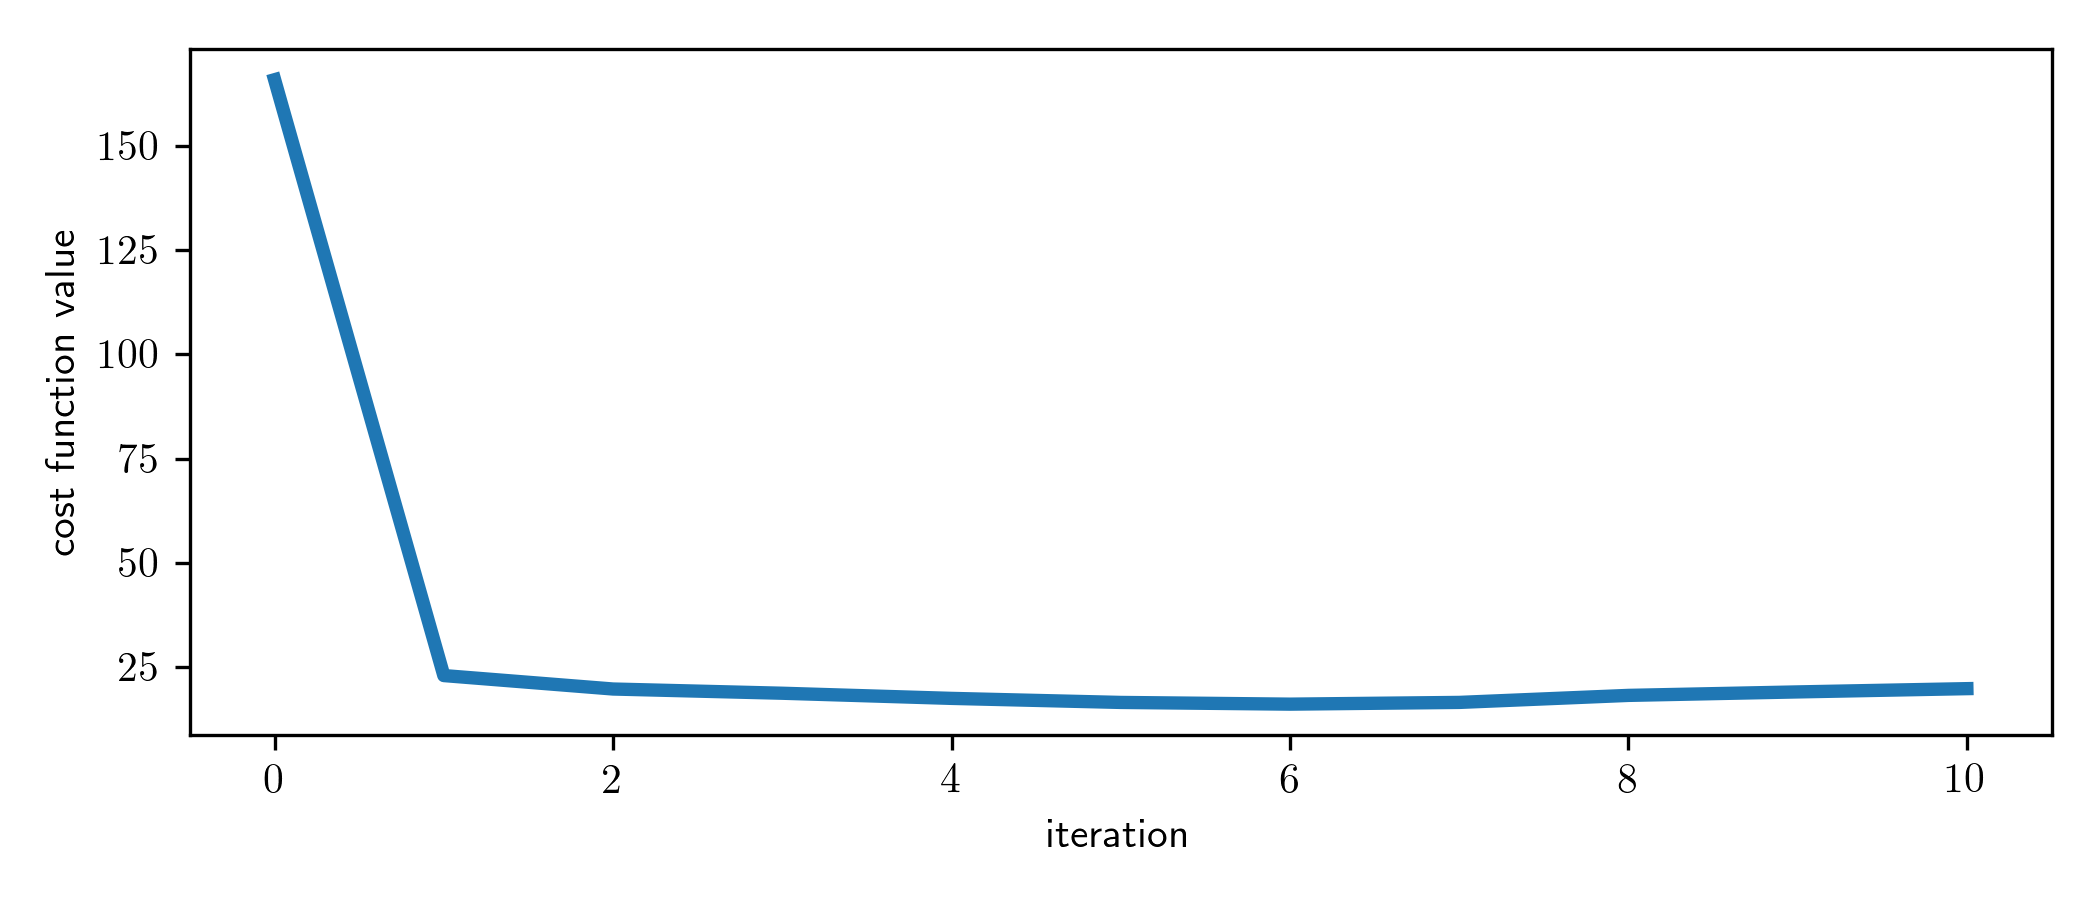

In [228]:
# generate initialization for basis
K = 5
C = np.random.randn(N,K)

# run recommender system
max_its = 10; lam = 10**(-5)
C_final,W_final,cost_history = Recommender_Systems(X_test,C,max_its=max_its,lam = lam)

# plot cost function history
plotter = unsuplib.plot_utilities.Visualizer()
plotter.plot_cost_history(cost_history)

Now, to get a sense of how well we can learn entries in the matrix we did *not* have to begin with we run the same experiment as above only over a range of values for $K=1,...,9$ and plot the cost function value on a) only the values we are given and b) the entire original matrix.  Afterwards we plot both cost function histories.

In [237]:
# run loop over different K
partial_costs = []
full_costs = []
ind = np.isnan(X_test)
ind = np.argwhere(ind == False).ravel()
    
# make a test matrix
my_ks = [1,2,3,4,5,6,7,8,9]
for K in my_ks:
    # generate initialization for basis
    C = np.random.randn(N,K)

    ### run recommender system algo
    max_its = 10; lam = 10**(-5)
    C_final,W_final,cost_history = Recommender_Systems(X_test,C,max_its=max_its,lam = lam)
   
    ### record cost on set of given entries, then on full matrix
    a = recommender_cost_function(X_test,C_final,W_final,lam = 0)
    b = recommender_cost_function(X_complete,C_final,W_final,lam = 0)

    # normalize each so we get a per-entry error
    a *= P/float(len(ind))
    b *= P/float(np.size(X_complete))
    partial_costs.append(a)
    full_costs.append(b)

<IPython.core.display.Javascript object>


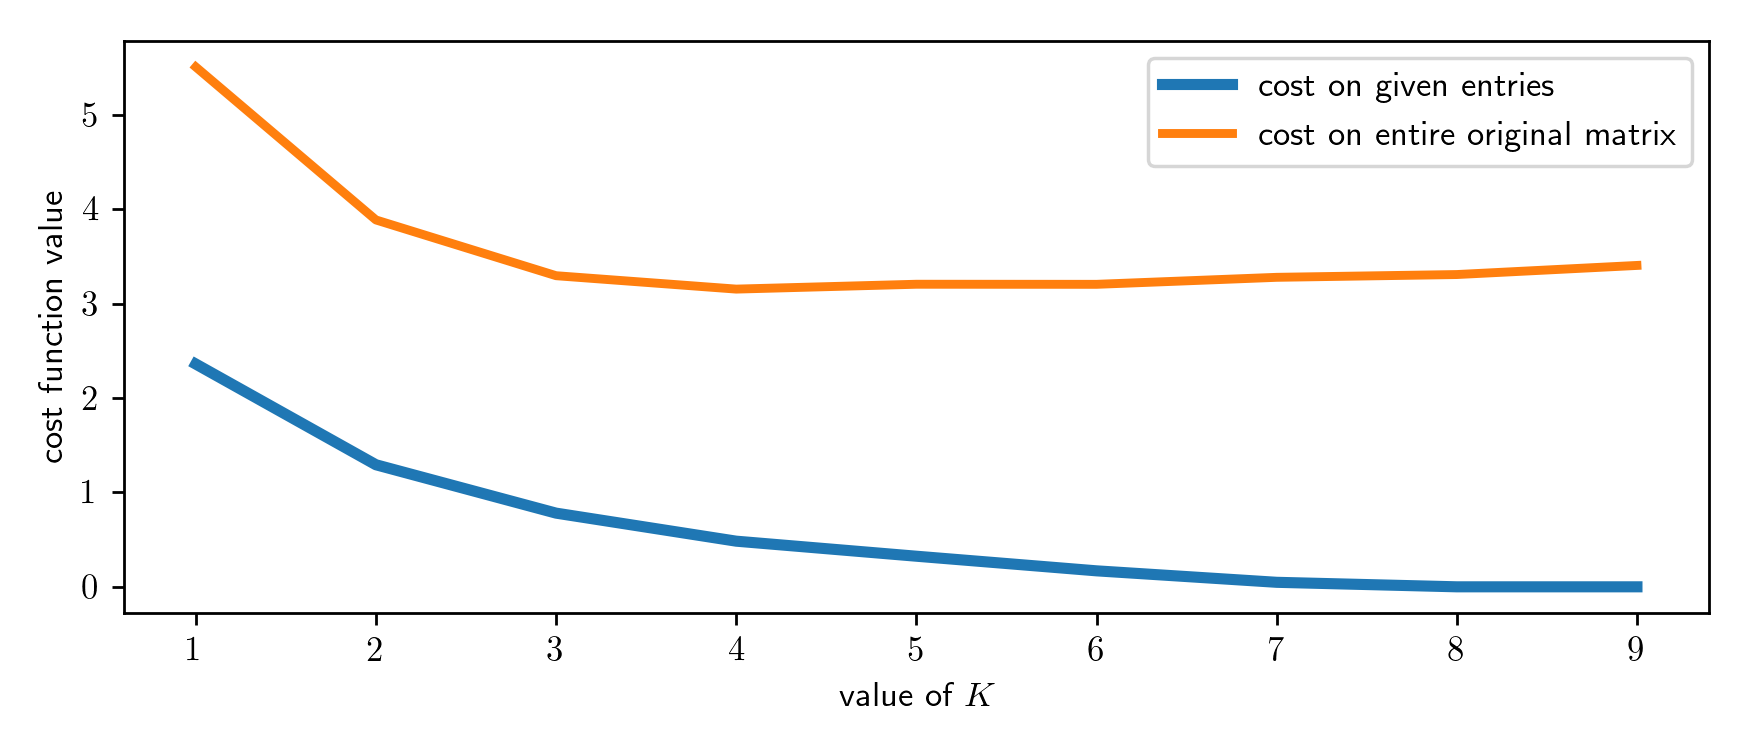

In [238]:
# plot cost function history
plotter = unsuplib.plot_utilities.Visualizer()
histories = [partial_costs,full_costs]
plotter.compare_histories(histories,label1 = 'cost on given entries',label2 = 'cost on entire original matrix',plot_range = my_ks)

The sort of behavior seen here - where the cost value on the full original matrix reaches a minimum for some intermediary value of $K$ - is quite common.  This is due to the fact that as we increase $K$ here we begin - after a certain value (here $K = 4$) -  to fit very well to our known entries at the expense of generalization (i.e., we begin to fit worse to values we cannot see).  This *overfitting* problem is a common one we will address more systematically in the next Chapter.  

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.